## Factors Affecting Weekly Walmart Sales
__Created by: Tuan Quang (Finn) Pham, Saniya Nadeem__
### A. Introduction:
- According to an article discussing the role of sales in business firms, Zach Lazzari (2018) argues that sales is a crucial element for the survival of an organization. Furthermore, it has a significant impact on other aspects of a business such as the firm's overall profit, brand image and most importantly, it reflects customers' perceptions of the organization. 

- In this project, we will be focusing on the weekly sales conditions of Walmart - a global corporation known for its extensive network of stores and diverse products offering. Specifically, we plan to assess several external factors we believe that will have an impact on the number of sales of the company. 

- Throughout this analysis, we hope to aid organizations in making informed decisions and optimizing business operations. From our perspective, with a predictive model of high accuracy level, Walmart will be able to proactively respond to market dynamics, mitigate risks, and capitalize emerging opportunites.Walmart can also use this to improve inventory management, optimize staffing levels, tailor promotional strategies, and enhance overall efficiency. This will help the firm maintain a competitive edge in the retail industry and can also help firm maximise profits. 

### B. Methods and Plans:
- __Research question of interest__: What is the weekly sales of Walmart based on the economics conditions and other events that presented throughout the week?
- __How will we answer our requestion__: We are aiming to build two different regression models: __multiple regression__ and __LASSO regression__. We will later on compare these two models by looking at the __Mean Squared Error__ (which indicates how far off our prediction is from the actual values) and finalize the best model at the end of this report. 
- __The dataset__: Our dataset was published by M. Yasser H. on Kaggle, we present below here a short glimpse of our dataset.
- __Variables in use__: We will be using `Holiday_Flag`, `Temperature`, `Fuel Price`, `CPI` and `Unemployment` as our explanatory variables. 

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math 
import seaborn as sns
import os
from sklearn.model_selection import train_test_split, cross_validate
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from scipy import stats

In [2]:
walmart_dt = pd.read_csv("https://raw.githubusercontent.com/tuanqpham/toy_ds_project/main/Walmart.csv")
walmart_dt.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


- An explanation of the variables (as provided by the onwer of the dataset):
    * `Store`: the store number (encoded as type integers in the dataset).
    * `Date`: the of sales in record.
    * `Weekly_Sales`: the number of sales in that week.
    * `Holiday_Flag`: indicates whether the week was a special holiday (1 = Holiday Week, 0 = Non-holiday week)
    * `Temperature`: temperature recorded in the week (in Farenheit).
    * `Fuel_Price`: cost of fuel in the region.
    * `Unemployment rate`: the unemployment rate
    * `CPI`: the Consumer Price Index.

### C. Assessing our data:
- In this section, we will be cleaning our dataset by keeping variables we believe are necessary in building our model. We will also be creatig visualizations to gain a better understanding of the relationships between the variables:
- Luckily for us, all column names are readable for the audience which means that there is no need for renaming
#### C.1. Data cleaning:
- It is important that we remove the rows and columns that are unecessary for our analysis.
- First. we begin by only dropping uncessary columns for our analysis. In our case, we will be dropping the store number column:

In [3]:
walmart_dt_drop = walmart_dt.drop(["Store"], axis = 1)
walmart_dt_drop.head()

,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


In [4]:
print(walmart_dt_drop.shape)
walmart_dt_new = walmart_dt_drop.dropna()
print(walmart_dt_new.shape)

(6435, 7)
(6435, 7)


Fortunately, our dataset does not contain any missing values. However, we believe it is quite rare in practice to obtain datasets with no missing values.

- In the next step, based on our statistical intuition, we also plan to eliminate outliers in our data as they negatively affect the accuracy level of our regression model.
- First, we will be creating a histogram plot visualizing the distribution of Weekly Sales.

[Text(0.5, 1.0, 'Distribution of Weekly Sales')]

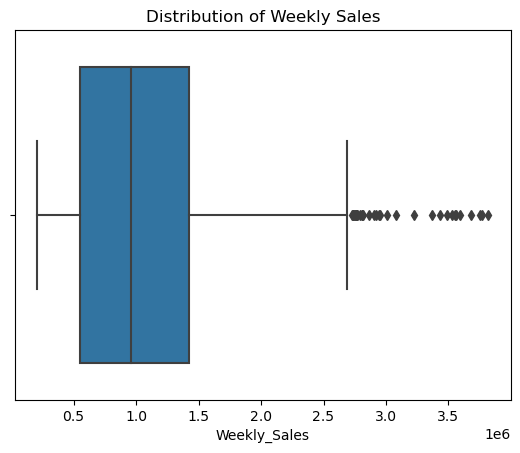

In [5]:
sns.boxplot(data = walmart_dt_new, x = "Weekly_Sales").set(title = "Distribution of Weekly Sales")

From this boxplot, we notice that there are signs of outliers in our dataset. Therefore, we decide to eliminate them in the following step:

In [6]:
#Finding the upper and lower bound of Weekly_Sales
lower = walmart_dt_new["Weekly_Sales"].quantile(0.25)
print(lower)
upper = walmart_dt_new["Weekly_Sales"].quantile(0.75)
print(upper)
iqr = upper - lower

max_bound = upper + (1.5*iqr)
min_bound = lower - (1.5*iqr)

# Setting all the values of Weekly Sales outside of desirable range into missing values.
walmart_dt_new.loc[walmart_dt_new["Weekly_Sales"] > max_bound, "Weekly_Sales"] = np.nan
walmart_dt_new.loc[walmart_dt_new["Weekly_Sales"] < min_bound, "Weekly_Sales"] = np.nan

#Dropping missing values and reset the index
walmart = walmart_dt_new.dropna()
walmart = walmart.reset_index()

553350.105
1420158.66


#### C.2: New variable creation:
- For our analysis, we decide to build regression models with the log of `Weekly_Sales` as the target value rather than using the original value. This is done as the relationship between our weekly sales and other predictor variables are not always linear. 

In [7]:
walmart["Log_WeeklySales"] = np.log(walmart["Weekly_Sales"])
walmart

,index,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Log_WeeklySales
0,0,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106,14.312455
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106,14.311400
2,2,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106,14.292966
3,3,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106,14.158907
4,4,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106,14.256862
...,...,...,...,...,...,...,...,...,...
6396,6430,28-09-2012,713173.95,0,64.88,3.997,192.013558,8.684,13.477481
6397,6431,05-10-2012,733455.07,0,64.89,3.985,192.170412,8.667,13.505522
6398,6432,12-10-2012,734464.36,0,54.47,4.000,192.327265,8.667,13.506897
6399,6433,19-10-2012,718125.53,0,56.47,3.969,192.330854,8.667,13.484400


### D: Building and evaluating our regression models:
#### D.1: Training and Testing Data splitting:
- As we notice in one of our predictors, the variable `Holiday_Flag` is actually a dummy variable. Therefore, when splitting our dataset into training and splitting datas, we want to ensure that both sets contain the same proportion of weeks recorded as holidays and non-holidays.
- We will be keeping 75% of the data for our training set.

In [8]:
#Splitting the dataset:
holiday = walmart.loc[walmart["Holiday_Flag"] == 1]
non_holiday = walmart.loc[walmart["Holiday_Flag"] == 0]

holiday_train, holiday_test = train_test_split(holiday, test_size = 0.25, random_state = 10)
non_holiday_train, non_holiday_test = train_test_split(non_holiday, test_size = 0.25, random_state = 10)

training_data = pd.concat([holiday_train, non_holiday_train])
testing_data = pd.concat([holiday_test, non_holiday_test])

#### D.2: Visualizations:
- As mentioned above, in this subsection, we will be creating visualizations to have a better understanding of the relationships between the variables. Furthermore, we can check whether our explanatory variables do a good job at predicting the log of weekly sales!
- First, we created boxplots illustrating the log weekly sales in holiday and non-holiday weeks to evaluate whether holiday status makes a difference in weekly market sales.

[Text(0.5, 1.0, 'Log Weekly Sales during Non-Holiday Weeks and Holiday Weeks')]

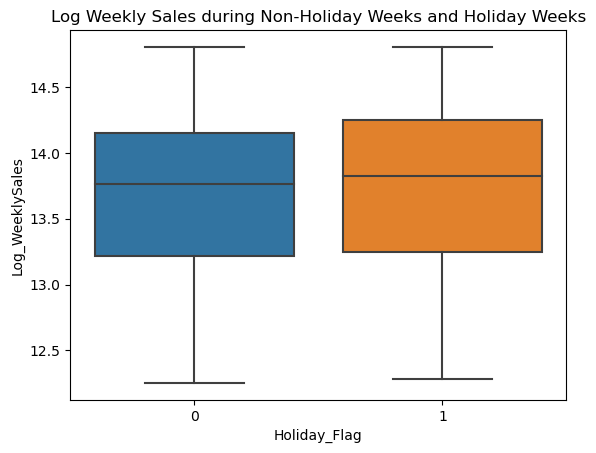

In [9]:
sns.boxplot(data = training_data, y = "Log_WeeklySales", x = "Holiday_Flag").set(title = "Log Weekly Sales during Non-Holiday Weeks and Holiday Weeks")


From the boxplots displayed above, we can see that the log weekly sales during holiday weeks is slightly higher than that during non-holiday weeks. However, given that this difference is not quite significant, we believe it is not the best predictor variable for our model.

- For our quantitative variables, we will first obtain their descriptive statistics:

In [10]:
training_data[["Temperature", "Fuel_Price", "CPI", "Unemployment"]].describe()

,Temperature,Fuel_Price,CPI,Unemployment
count,4800.00000,4800.000000,4800.000000,4800.000000
mean,60.98050,3.367021,171.098244,7.998198
std,18.25877,0.458591,39.390360,1.889282
min,-2.06000,2.472000,126.064000,3.879000
25%,47.95750,2.938000,131.193097,6.891000
50%,63.03000,3.473000,182.258701,7.866000
75%,75.09000,3.741000,212.833640,8.622250
max,100.14000,4.468000,227.232807,14.313000


Then, we create 4 different scatterplots showing the relationships between each of our predictor variables with the log linear weekly sales:

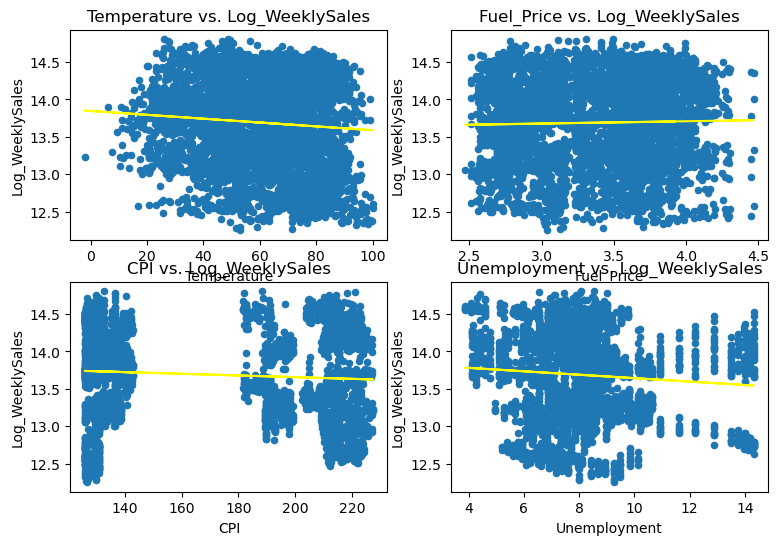

In [11]:
fig, axes = plt.subplots(2, 2, figsize = (9,6))
col_names = ["Temperature", "Fuel_Price", "CPI", "Unemployment"]

for a in range(len(col_names)):
    if a < 2:
        training_data.plot.scatter(x = col_names[a], y = "Log_WeeklySales", ax = axes[0, a])
        axes[0, a].set_title(f"{col_names[a]} vs. Log_WeeklySales")
        m,b = np.polyfit(training_data[col_names[a]], training_data["Log_WeeklySales"], 1)
        axes[0, a].plot(training_data[col_names[a]], m*(training_data[col_names[a]]) + b, color = "yellow")
    else:
        training_data.plot.scatter(x = col_names[a], y = "Log_WeeklySales", ax = axes[1, a-2])
        axes[1, a-2].set_title(f"{col_names[a]} vs. Log_WeeklySales")
        m,b = np.polyfit(training_data[col_names[a]], training_data["Log_WeeklySales"], 1)
        axes[1, a-2].plot(training_data[col_names[a]], m*(training_data[col_names[a]]) + b, color = "yellow")


From the above plots, we discovered that there is a very weak to no relationship between the predictor variables and response variable. This suggests the vairiables in use might not be the best predictors of Walmart weekly sales.

To understand the relationship between the variables numerically, we have obtained the following correlation matrix using colors to demonstrate the strength of the correlation.

<Axes: >

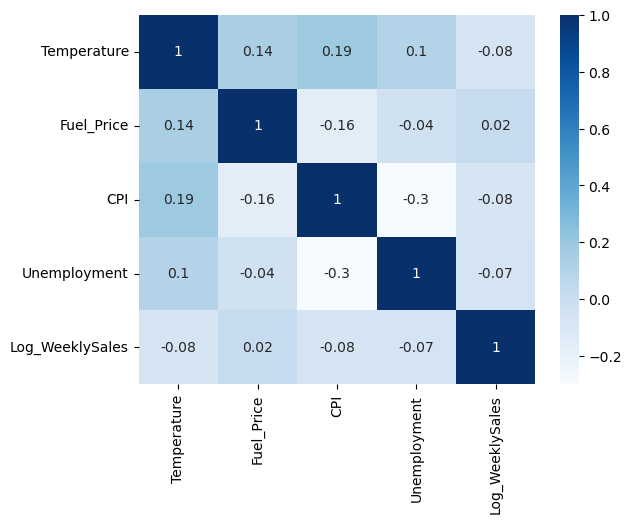

In [12]:
correlation_matrix = round(training_data[["Temperature", "Fuel_Price", "CPI", "Unemployment", "Log_WeeklySales"]].corr(), 2)
sns.heatmap(correlation_matrix, cmap = "Blues", annot = True)

#### D.3: Performing regression and obtain error statistics:
##### Linear Regression:
- In this subsection, we will be fitting our regression model using 

In [13]:
X_train = training_data[["Temperature", "Fuel_Price", "CPI", "Unemployment", "Holiday_Flag"]]
y_train = training_data["Log_WeeklySales"]
X_test = testing_data[["Temperature", "Fuel_Price", "CPI", "Unemployment", "Holiday_Flag"]]
y_test = testing_data["Log_WeeklySales"]


model = linear_model.LinearRegression()
model.fit(X_train, y_train)
mse_train = mean_squared_error(y_train, model.predict(X_train))
print(mse_train)
mse_test = mean_squared_error(y_test, model.predict(X_test))
print(mse_test)

0.33423595803089307
0.32928753482512235


Text(0.5, 1.0, 'Relationship between predicted and actual log weekly Walmart Sales')

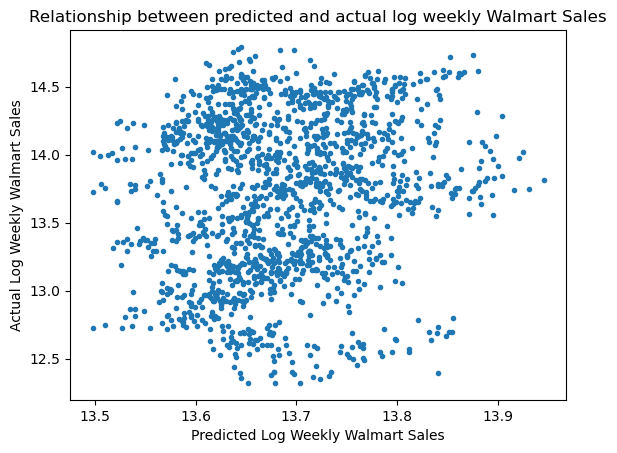

In [19]:
plt.plot(model.predict(X_test), y_test, ".")
plt.xlabel("Predicted Log Weekly Walmart Sales")
plt.ylabel("Actual Log Weekly Walmart Sales")
plt.title("Relationship between predicted and actual log weekly Walmart Sales")

In [30]:
dt = pd.DataFrame(model.predict(X_test), y_test)
dt.rename(columns = {"Log_WeeklySales": "Actual",
                     0: "Predicted"}).reset_index().corr()


,Log_WeeklySales,Predicted
Log_WeeklySales,1.000000,0.150265
Predicted,0.150265,1.000000


In [34]:
la_model = linear_model.Lasso()
la_model.fit(X_train, y_train)
mse_train = mean_squared_error(y_train, la_model.predict(X_train))
print(mse_train)
mse_test = mean_squared_error(y_test, la_model.predict(X_test))
print(mse_test)

0.33940741648701894
0.3354562166363967


Text(0.5, 1.0, 'Relationship between predicted and actual log weekly Walmart Sales')

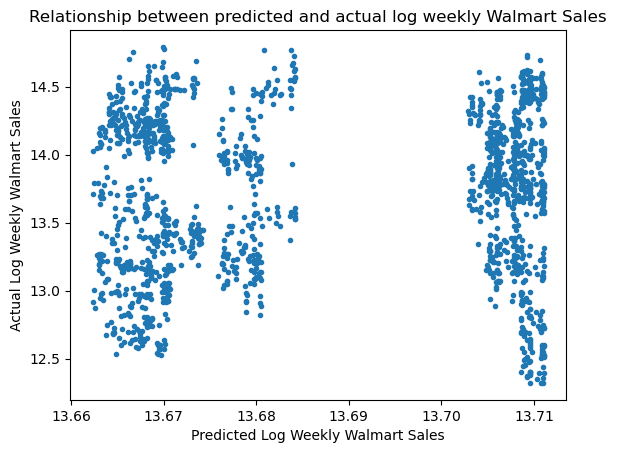

In [35]:
plt.plot(la_model.predict(X_test), y_test, ".")
plt.xlabel("Predicted Log Weekly Walmart Sales")
plt.ylabel("Actual Log Weekly Walmart Sales")
plt.title("Relationship between predicted and actual log weekly Walmart Sales")

In [36]:
dt = pd.DataFrame(la_model.predict(X_test), y_test)
dt.rename(columns = {"Log_WeeklySales": "Actual",
                     0: "Predicted"}).reset_index().corr()

,Log_WeeklySales,Predicted
Log_WeeklySales,1.000000,0.074542
Predicted,0.074542,1.000000


##### Random Forest:


In [39]:
rdf = RandomForestRegressor(n_estimators = 10,
                           max_depth = 10,
                           random_state = 123)
rdf.fit(X_train, y_train)
mse_train = mean_squared_error(y_train, rdf.predict(X_train))
mse_test = mean_squared_error(y_test, rdf.predict(X_test))

print(mse_train)
print(mse_test)

0.17628490915181605
0.2179451057386171


Text(0.5, 1.0, 'Relationship between predicted and actual log weekly Walmart Sales')

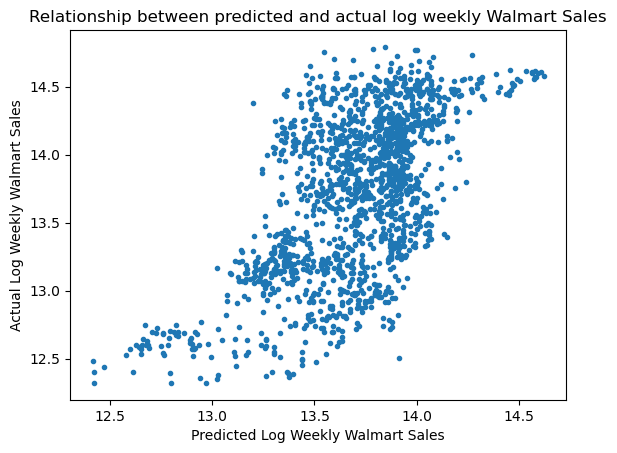

In [40]:
plt.plot(rdf.predict(X_test), y_test, ".")
plt.xlabel("Predicted Log Weekly Walmart Sales")
plt.ylabel("Actual Log Weekly Walmart Sales")
plt.title("Relationship between predicted and actual log weekly Walmart Sales")

In [41]:
dt = pd.DataFrame(rdf.predict(X_test), y_test)
dt.rename(columns = {"Log_WeeklySales": "Actual",
                     0: "Predicted"}).reset_index().corr()

,Log_WeeklySales,Predicted
Log_WeeklySales,1.000000,0.595946
Predicted,0.595946,1.000000
